In [1]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")
import os, sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))
import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings('ignore')
from scipy.spatial.distance import correlation as Dcorr
import bambi as bmb
import arviz as az
import json
import pickle
import bammm.bammm as mm
# load main dataset
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete.csv"))

##### VERY IMPORTANT ####
df["state_severity"] = df["deaths7_norm"]


### Meta parameters
corr_type = "spearman" # used in all analyses

#data = df.groupby(by=["PROLIFICID"])["stai_sa", "state_severity"].corr()
factors =[ "F1_Close_Person_Worry","F2_Anxiety_Avoidance", "F3_Economic_Impact_Worry", "F4_Prob_Estimates", "F5_Worry", "F6_Skepticism"]
print("State seveirty NaNs: "+str(df["state_severity"].isna().sum())+" out of entries: "+ str(df.shape[0]))

no_trait_factors = 5
if no_trait_factors == 6:
        trait_factor_names = ["TF1_Self_Consciousness", "TF2_Positive", "TF3_Catastrophizing",  "TF4_Physiological_Anx",  "TF5_Depression",  "TF6_Cognitive_Anx"]
elif no_trait_factors==5:
    trait_factor_names = ["TF1_Worry", "TF2_Self_Worth", "TF3_Catastrophizing",  "TF4_Anxiety",  "TF5_Depression"]

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


State seveirty NaNs: 190 out of entries: 5809


## Separate characerization of the two waves of COVID in 2020
- this notebook attempts to characterize the falling and the rizing of covid cases in 2020 and link it to personality measures 

In [2]:
### 

<Figure size 432x288 with 0 Axes>

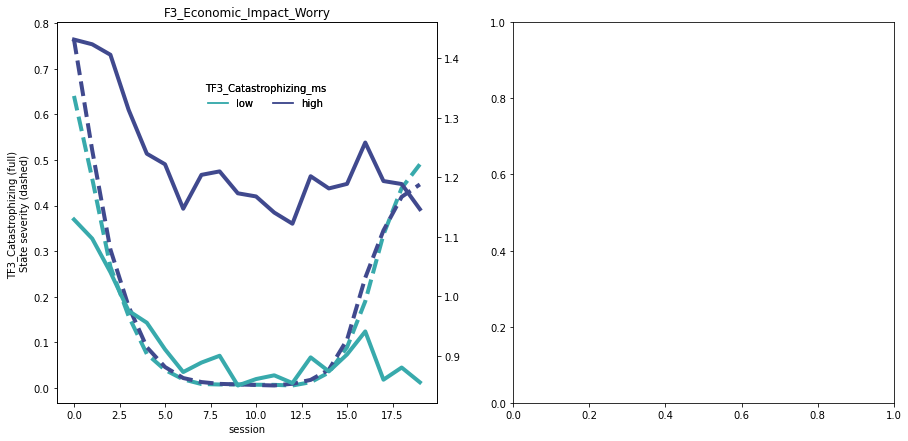

In [3]:
for tt in [trait_factor_names[2]]:
    splitvar = tt+"_ms" #"stai_ta_ms" #"TF4_Physiological_Anx_ms" # "stai_ta_ms" 
    data = df.groupby(["session", splitvar])[[ "state_severity"]+factors].mean()
    plt.figure()
    fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(15,7))
    #plt.subplots_adjust(wspace=0.4)
    f_idx = 0
    f = factors[2]
    g = sns.lineplot(data=data, x="session", y="state_severity", hue=splitvar, hue_order=["low", "high"],linewidth = 4, palette=sns.color_palette("mako_r", 2), ax=ax[f_idx])
    g.set_title(f)
    g.set_ylabel("")
    sns.move_legend(ax[f_idx], "lower center", bbox_to_anchor=(0.55, 0.75), ncol=3, frameon=False)
    if f_idx == 0:
        g.set_ylabel(tt+" (full) \nState severity (dashed)")
    for lidx, l in enumerate(ax[f_idx].lines):
        ax[f_idx].lines[lidx].set_linestyle("--")
    ax[f_idx].grid(False)
    g2 = ax[f_idx].twinx()
    g = sns.lineplot(data=data, x="session", y=f, hue=splitvar, hue_order=["low", "high"], linewidth = 4,palette=sns.color_palette("mako_r", 2), ax=g2)
    sns.move_legend(g2, "lower center", bbox_to_anchor=(0.55, 0.75), ncol=3, frameon=False)
    g.set_ylabel("")


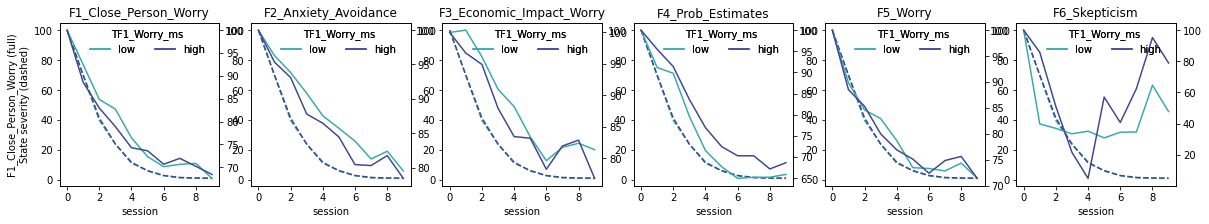

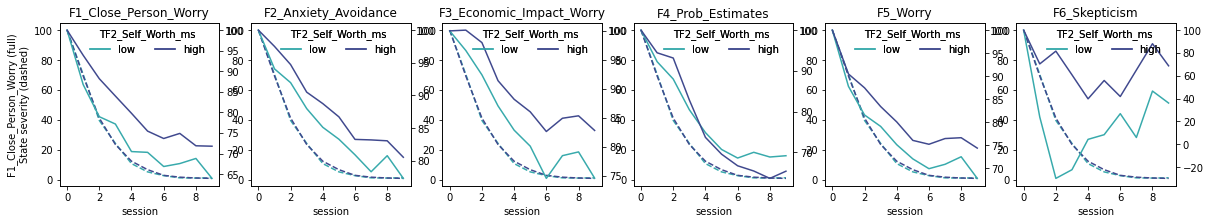

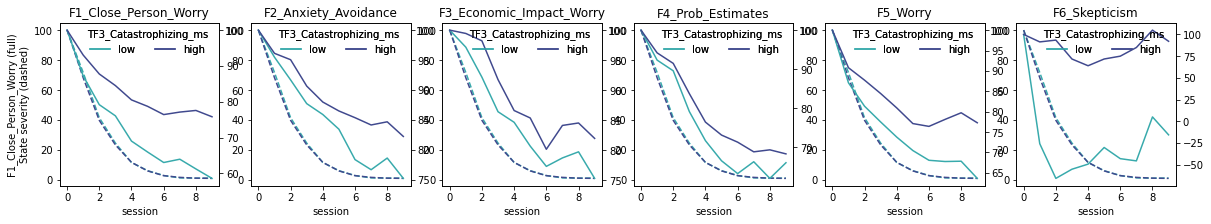

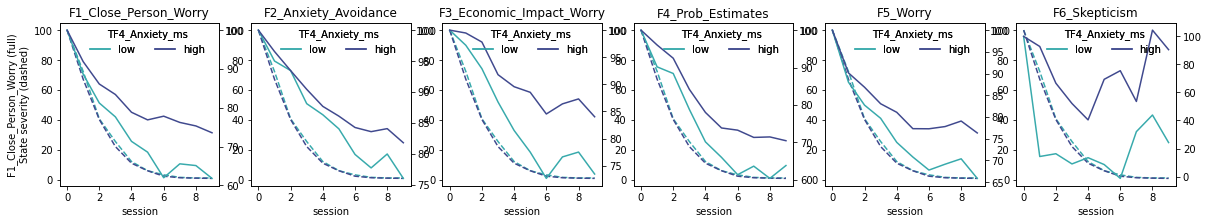

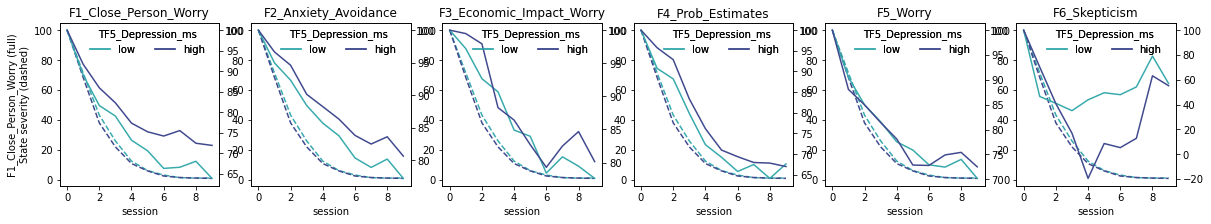

In [4]:
cutoff_session = 9

for tt in trait_factor_names:
    splitvar = tt+"_ms" #"stai_ta_ms" #"TF4_Physiological_Anx_ms" # "stai_ta_ms" 
    data = df.groupby(["session", splitvar])[[ "state_severity"]+factors].mean()
    dt = data.reset_index()
    dtlow = dt.loc[(dt["session"]<=cutoff_session) & (dt[tt+"_ms"].isin(["low"])),:].reset_index()
    dthigh = dt.loc[(dt["session"]<=cutoff_session) & (dt[tt+"_ms"].isin(["high"])),:].reset_index()
    for f in factors+["state_severity"]:
        dtlow.loc[:,f] = (100*(dtlow.loc[:,f] / dtlow.loc[0,f]))
        dthigh.loc[:,f] = (100*(dthigh.loc[:,f] / dthigh.loc[0,f]))
    dt = pd.concat([dtlow, dthigh]).reset_index()
   
    fig, ax = plt.subplots(ncols=6,nrows=1,figsize=(20,3))
    for f_idx, f in enumerate(factors):
        g = sns.lineplot(data=dt, x="session", y="state_severity", hue=splitvar, 
                         hue_order=["low", "high"], palette=sns.color_palette("mako_r", 2), 
                         ax=ax[f_idx])
        #ax[f_idx].set_ylim([-1, 0.1])
        g.set_title(f)
        g.set_ylabel("")
        
        if f_idx == 0:
            g.set_ylabel(f+" (full)\nState severity (dashed)")
        for lidx, l in enumerate(ax[f_idx].lines):
            ax[f_idx].lines[lidx].set_linestyle("--")
        g2 = ax[f_idx].twinx()
        g = sns.lineplot(data=dt, x="session", y=f, hue=splitvar, hue_order=["low", "high"], palette=sns.color_palette("mako_r", 2), ax=g2)
        sns.move_legend(g2, "lower center", bbox_to_anchor=(0.55, 0.75), ncol=3, frameon=False)
        #sns.move_legend(g2, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
        g.set_ylabel("")
        #g.set_ylim([-1, 0.1])
        sns.move_legend(ax[f_idx], "lower center", bbox_to_anchor=(0.55, 0.75), ncol=3, frameon=False)
        #g.set_title(f)


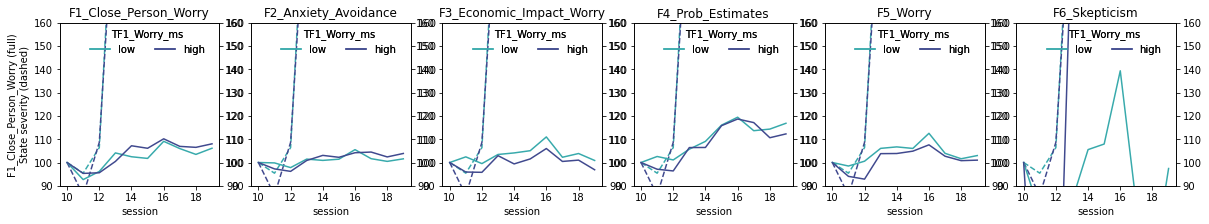

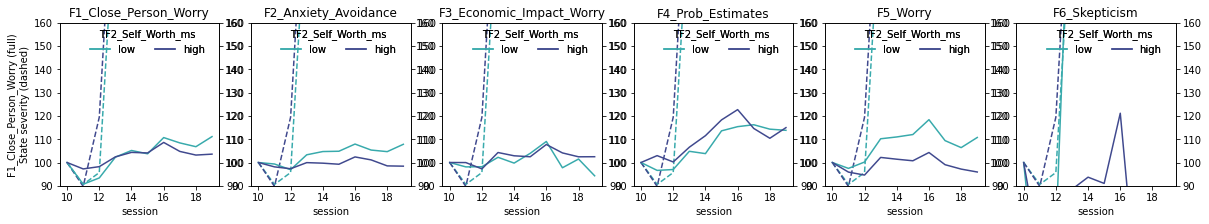

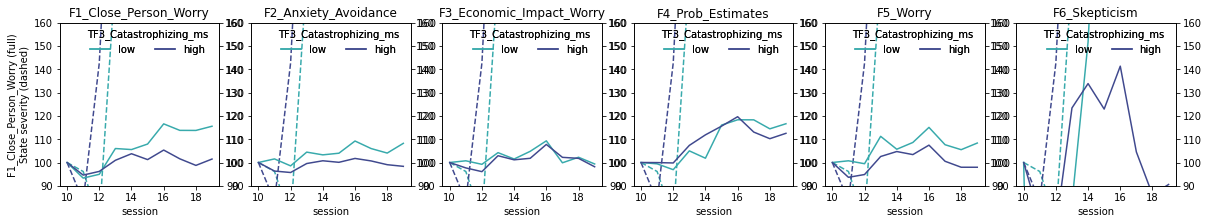

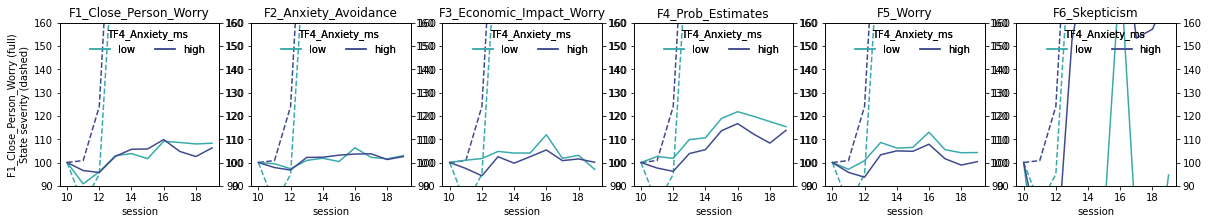

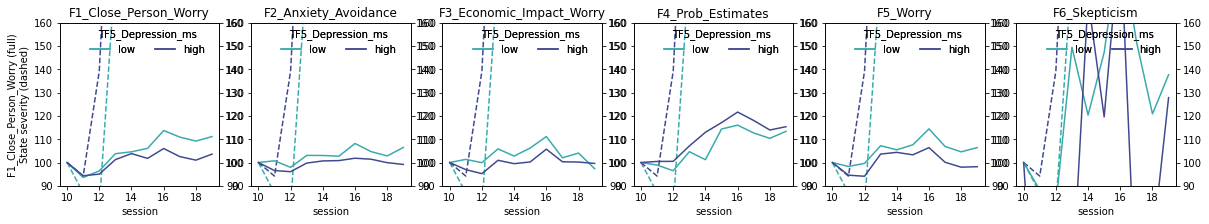

In [5]:
cutoff_session = 9

for tt in trait_factor_names:
    splitvar = tt+"_ms" #"stai_ta_ms" #"TF4_Physiological_Anx_ms" # "stai_ta_ms" 
    data = df.groupby(["session", splitvar])[[ "state_severity"]+factors].mean()
    dt = data.reset_index()
    dtlow = dt.loc[(dt["session"]>cutoff_session) & (dt[tt+"_ms"].isin(["low"])),:].reset_index()
    dthigh = dt.loc[(dt["session"]>cutoff_session) & (dt[tt+"_ms"].isin(["high"])),:].reset_index()
    for f in factors+["state_severity"]:
        #dtlow.loc[:,f] = dtlow.loc[:,f] - dtlow.loc[0,f]
        #dthigh.loc[:,f] = dthigh.loc[:,f] - dthigh.loc[0,f]
        dtlow.loc[:,f] = (100*(dtlow.loc[:,f] / dtlow.loc[0,f]))
        dthigh.loc[:,f] = (100*(dthigh.loc[:,f] / dthigh.loc[0,f]))
    dt = pd.concat([dtlow, dthigh]).reset_index()
   
    fig, ax = plt.subplots(ncols=6,nrows=1,figsize=(20,3))
    for f_idx, f in enumerate(factors):
        g = sns.lineplot(data=dt, x="session", y="state_severity", hue=splitvar, 
                         hue_order=["low", "high"], palette=sns.color_palette("mako_r", 2), 
                         ax=ax[f_idx])
        #ax[f_idx].set_ylim([-1, 0.1])
        g.set_title(f)
        g.set_ylabel("")
        g.set_ylim([90, 160])
        
        if f_idx == 0:
            g.set_ylabel(f+" (full)\nState severity (dashed)")
        for lidx, l in enumerate(ax[f_idx].lines):
            ax[f_idx].lines[lidx].set_linestyle("--")
        g2 = ax[f_idx].twinx()
        g = sns.lineplot(data=dt, x="session", y=f, hue=splitvar, hue_order=["low", "high"], palette=sns.color_palette("mako_r", 2), ax=g2)
        sns.move_legend(g2, "lower center", bbox_to_anchor=(0.55, 0.75), ncol=3, frameon=False)
        #sns.move_legend(g2, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
        g.set_ylabel("")
        g.set_ylim([90, 160])
        #g.set_ylim([-1, 0.1])
        sns.move_legend(ax[f_idx], "lower center", bbox_to_anchor=(0.55, 0.75), ncol=3, frameon=False)
        #g.set_title(f)